# PE job postings dataset

Authors: stephan@bayes.org, pascal@bayes.org

This notebook provides a quick overview over the job postings dataset. This dataset mostly includes job offers syndicated by Pole Emploi, but unfortunately does not include the data from all job boards. It still provides a large portion of all job postings in France, and though incomplete is an extremely valuable source of data. 

Because the extracted CSV is about 13GB, and creates trouble when attempted to be loaded into memory, I created a 10% sample of this file using some perl magic. If you want to create another sample run the following command, within the folder into which you extracted the CSV:

`perl -ne 'print if (rand() < .1)' OFFRE_EXTRACT_ENRICHIE_FGU_18JANV2016.csv > sample_10perc.csv`

In this notebook I want to provide an overview of what can be found in the dataset, have some basic descriptive statistics and answer the following questions:

* For which period of time do we have data?
* What is the coverage of this dataset in terms of job groups and jobs?
* How complete is the listing of *job requirements* in this dataset?
* Can we see seasonality effects when looking at single jobs?
* Can we visualize how the *minimum accepted salary* of a jobseeker influences the number of job postings?
* Are required skills listed with the job postings?
    - If yes, can we use this to tell a job seeker how the number of listings would change with the acquisition of new jobs?

In [1]:
import sys
import os
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as _

from paul_emploi.lib import job_offers as job_offers_lib
from paul_emploi.lib import plot_helpers, cleaned_data

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%matplotlib inline

## Read the data

The sample file, provided in the zip, is only read to extract the column names from it, because the big CSV does not come with a header. 

The reading will show a warning for mixed types. We could solve this by explicitly specifying types for each column. But this would be too much effort and I will just convernt single columns when needed.

In [2]:
postings = cleaned_data.job_offers(data_folder='../../data', filename_offers="job_offers/sample_10perc.csv")
postings.head(2)

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (1,2,6,7,10,11,20,21,23,24,27,28,30,31,32,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,92,94,95,96,97,98,100,102,104,105,106,107,108,109,110,111,112,115,119,120,124,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,id_offre,date_debut_validite_offre,date_fin_validite_offre,nb_vacancies_creation,status_code,status_name,experience_code,experience_name,experience_min_duration,experience_max_duration,exp_duration_type_code,exp_duration_type_name,rome_profession_card_code,rome_profession_card_name,rome_profession_code,rome_profession_name,contract_nature_code,contract_nature_name,contract_type_code,contract_type_name,contract_dur_unit_code,contract_dur_unit_name,contract_duration,salary_type_code,salary_type_name,minimum_salary,maximum_salary,salary_unit_code,wage_unit_name,nb_month_salary,salary_comment,activity_code,activity_name,creation_date,modification_date,qualification_code,qualification_name,working_condition_code,working_condition_name,working_hours_type_code,working_hours_type_name,working_condition_comment,working_hours_type_comment,weekly_working_hours,weekly_working_minutes,rome_list_skill_code,rome_list_activity_code,rome_list_work_env_code,degree_type_code_1,degree_type_name_1,degree_subject_area_code_1,degree_subject_area_name_1,degree_diploma_name_1,degree_required_code_1,degree_required_name_1,degree_type_code_2,degree_type_name_2,degree_subject_area_code_2,degree_subject_area_name_2,degree_diploma_name_2,degree_required_code_2,degree_required_name_2,lang_code_1,lang_name_1,lang_proficiency_code_1,lang_proficiency_name_1,lang_required_code_1,lang_required_name_1,lang_code_2,lang_name_2,lang_proficiency_code_2,lang_proficiency_name_2,lang_required_code_2,lang_required_name_2,driving_lic_code_1,driving_lic_name_1,driving_lic_req_code_1,driving_lic_req_name_1,driving_lic_code_2,driving_lic_name_2,driving_lic_req_code_2,driving_lic_req_name_2,desktop_tools_code_1,desktop_tools_name_1,desktop_tools_lev_code_1,desktop_tools_lev_name_1,desktop_tools_code_2,desktop_tools_name_2,desktop_tools_lev_code_2,desktop_tools_lev_name_2,salary_supplement_code_1,salary_supplement_name_1,salary_supplement_code_2,salary_supplement_name_2,working_location_type_code,working_location_type_name,working_location_name,country_code,country_name,region_code,region_name,departement_code,departement_name,city_code,city_name,postcode,sub_continent_code,sub_continent_name,continent_code,continent_name,disabled_accessibility,annual_minimum_salary,annual_maximum_salary,travel_frequency_code,travel_frequency_name,travel_frequency_comment,travel_type_code,travel_type_name,travel_type_comment,em_interview_modality_code,em_interview_modality_name,service_type_code,service_type_name,monitoring_agency_code,employer_consent,number_of_application,nb_vacancies_left,latitude,longitude,eff_cle,rome_id,rome_name,date_debut_imputed
0,000053Q,NaT,NaN,1,AN,Annulée,E,Expérience exigée,60,0,MO,An(s),F1106,Ingénierie et études du BTP ...,11753,Chargé / Chargée d'affaires de la construction...,E1,Contrat travail,CDI,Contrat à durée indéterminée,NaN,NaN,0,A,Annuel,30000.0,0.0,EU,Euros,12.0,+PART VARIABLE(RESULTAT/OBJECTIF),3101Z,Fabrication de meubles de bureau et de magasin,2012-08-16,2014-06-21 00:00,9,Cadre,NaN,NaN,NOR,NaN,NaN,FRAIS REELS REMBOURSES SUR JUSTIF.,39,0,23012|,650|1922|3181|3217|5372|5790|5794|5817|,23418|,NV4,Bac ou équivalent,0.0,Pas de domaine,FORTE ORIENTATION SECTEUR COMMERCIAL,S,Souhaité,NaN,NaN,0,Pas de domaine,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,Autre,0,Autre,CO,Une commune,PARTHENAY (2JOURS /SEMAINE),1,France,54,POITOU-CHARENTES,79,Deux-Sèvres,79202,PARTHENAY,79200,NaN,NaN,00,France (continent fictif),N,30000.0,0.0,0.0,Autre,3 JOURS / 5 EN MOYENNE,0.0,Autre,NaN,MEL,Envoyer votre CV par mail,ACC,Accompagnement au recrutement,79035.0,NaN,NaN,0,46.65,-0.25,NaN,F1106,Ingénierie et études du BTP,2012-08-16
1,000129Q,NaT,NaN,1,AN,Annulée,D,Débutant accepté,0,0,NaN,NaN,G1204,Éducation en activités sportives ...,16733,Moniteur / Monitrice de sport ...,E1,Contrat travail,CDI,Contrat à durée indéterminée,NaN,NaN,0,H,Horaire,9.4,0.0,EU,Euros,12.0,ET PLUS SELON EXPERIENCE,0143Z,Éleva

In [3]:
postings.describe(include='all')

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,id_offre,date_debut_validite_offre,date_fin_validite_offre,nb_vacancies_creation,status_code,status_name,experience_code,experience_name,experience_min_duration,experience_max_duration,exp_duration_type_code,exp_duration_type_name,rome_profession_card_code,rome_profession_card_name,rome_profession_code,rome_profession_name,contract_nature_code,contract_nature_name,contract_type_code,contract_type_name,contract_dur_unit_code,contract_dur_unit_name,contract_duration,salary_type_code,salary_type_name,minimum_salary,maximum_salary,salary_unit_code,wage_unit_name,nb_month_salary,salary_comment,activity_code,activity_name,creation_date,modification_date,qualification_code,qualification_name,working_condition_code,working_condition_name,working_hours_type_code,working_hours_type_name,working_condition_comment,working_hours_type_comment,weekly_working_hours,weekly_working_minutes,rome_list_skill_code,rome_list_activity_code,rome_list_work_env_code,degree_type_code_1,degree_type_name_1,degree_subject_area_code_1,degree_subject_area_name_1,degree_diploma_name_1,degree_required_code_1,degree_required_name_1,degree_type_code_2,degree_type_name_2,degree_subject_area_code_2,degree_subject_area_name_2,degree_diploma_name_2,degree_required_code_2,degree_required_name_2,lang_code_1,lang_name_1,lang_proficiency_code_1,lang_proficiency_name_1,lang_required_code_1,lang_required_name_1,lang_code_2,lang_name_2,lang_proficiency_code_2,lang_proficiency_name_2,lang_required_code_2,lang_required_name_2,driving_lic_code_1,driving_lic_name_1,driving_lic_req_code_1,driving_lic_req_name_1,driving_lic_code_2,driving_lic_name_2,driving_lic_req_code_2,driving_lic_req_name_2,desktop_tools_code_1,desktop_tools_name_1,desktop_tools_lev_code_1,desktop_tools_lev_name_1,desktop_tools_code_2,desktop_tools_name_2,desktop_tools_lev_code_2,desktop_tools_lev_name_2,salary_supplement_code_1,salary_supplement_name_1,salary_supplement_code_2,salary_supplement_name_2,working_location_type_code,working_location_type_name,working_location_name,country_code,country_name,region_code,region_name,departement_code,departement_name,city_code,city_name,postcode,sub_continent_code,sub_continent_name,continent_code,continent_name,disabled_accessibility,annual_minimum_salary,annual_maximum_salary,travel_frequency_code,travel_frequency_name,travel_frequency_comment,travel_type_code,travel_type_name,travel_type_comment,em_interview_modality_code,em_interview_modality_name,service_type_code,service_type_name,monitoring_agency_code,employer_consent,number_of_application,nb_vacancies_left,latitude,longitude,eff_cle,rome_id,rome_name,date_debut_imputed
count,1106851,604359,586989,1.106851e+06,1106851,1106851,776653,776653,1.106851e+06,1.106851e+06,496510,496510,1106811,1106811,1.106851e+06,1106799,1106851,1106851,1106851,1106851,462214,462214,1.106851e+06,776655,776655,844575.000000,844575.000000,776655,776655,1.106340e+06,139204,776498,776498,1106851,1106851,1.106851e+06,1106851,683566,683566,744436,683566,8928,53896,1106851.0,1106851.0,171241,309192,138472,296847,296846,1.106849e+06,168427,110370,296846,296847,37671,37671,1106850.0,168427,15991,37671,37670,54679,54679,844574.0,54652,54652,54652,9390,9392,844574.0,9386,9386,9386,183805,183804,183805,183804,5852,183804,5852,5852,81965,81964,844574.0,10859,69953,69953,844575.0,9416,844574.0,844575,844574.0,844574,776497,776279,776493,776435,776436,768324,755161,747092,747051,642490,642489,642254.0,4767,4767,776617,776618,729534,1.106850e+06,1.106849e+06,844575.000000,844574,22926,844574.000000,844574,1.000000,776653,776654,1008574,1008574,1.106850e+06,476120,27749.000000,1106850.0,573190.0,565683,1,1106811,1106811,1106851
unique,1106842,761,760,NaN,6,6,3,3,NaN,NaN,1,2,530,530,NaN,8942,26,26,13,13,2,2,NaN,5,5,NaN,NaN,1,1,NaN,46784,723,723,2032,44,NaN,9,6,6,10,6,5978,29804,109.0,77.0,32648,79552,6755,11,10,NaN,888,48381,2,3,11,11,1079.0,502,7854,3,2,50,50,13.0,6,2,2,46,48,13.0,5,2,2,21,20,3,2,20,20,3,3,3,3,10.0,4,4,4,14.0,5,23.0,13,23.0,12,7,5

## Time period of the data.

In [4]:
postings.creation_date.notnull().sum() / len(postings)

1.0

Nice, all of them have a creation date. Let's visualize this.

In [5]:
postings_ts = postings.set_index(pd.DatetimeIndex(postings.creation_date))
postings_ts.id_offre.resample('M').sum().head()
#ax = postings_ts.resample('M').id_offre.count().plot(kind='line')
#_ = ax.set_title('Job postings per month over time')

2004-01-31    992HFBC
2004-02-29          0
2004-03-31          0
2004-04-30          0
2004-05-31          0
Freq: M, Name: id_offre, dtype: object

There seem to be some outliers, but most postings are from between 2011 and 2016.

### Activation date

Some offers don't become active immediately. When this date is given, how big is the difference to the creation date?

97.49% of values in range


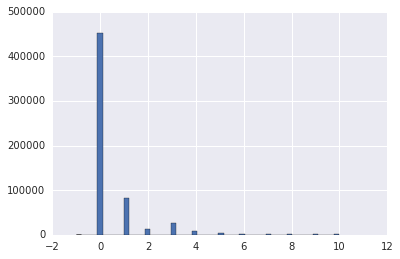

In [6]:
time_difference_days = (postings.date_debut_validite_offre - postings.creation_date).astype('timedelta64[D]')
_ = plot_helpers.hist_in_range(time_difference_days, max_value=10)

In [7]:
time_difference_days.loc[time_difference_days > 0].mean()

6.1911074597436739

Here is what we got about the date :
- availability_date got 45% missing values
- creation_date differs from availability_date 25% of time (at least 1 day of difference)
- when creation_date & availability_date differs, the average difference is 6 days.

Even though the difference is relatively small, we decided to use `availibility_date` when avaliable and impute `creation_date` when missing.

And suggest to do so in all further usage of the job_offers dataset.

## Completeness regarding job groups and jobs

In [8]:
postings.rome_profession_card_code.nunique()

530

17.379245283


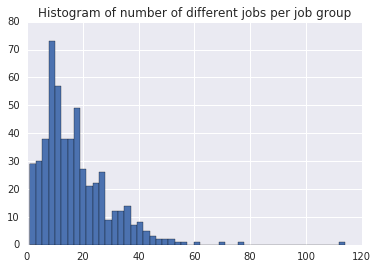

In [9]:
ax = postings.groupby('rome_profession_card_code').rome_profession_code.nunique().hist(bins=50)
print(postings.groupby('rome_profession_card_code').rome_profession_code.nunique().mean())
_ = ax.set_title('Histogram of number of different jobs per job group')

That's great coverage. Even within this 10% sample we have data for 530 (out of 531) job groups. Also within each job group we have an average of 17 different jobs listed.

## Format of qualification requirements

In [10]:
degree_1_columns = [c for c in postings.columns if 'degree' in c and '1' in c and 'name' in c]
postings[degree_1_columns].head(10)

,degree_type_name_1,degree_subject_area_name_1,degree_diploma_name_1,degree_required_name_1
0,Bac ou équivalent,Pas de domaine,FORTE ORIENTATION SECTEUR COMMERCIAL,Souhaité
1,Bac ou équivalent,Pas de domaine,BPJEPS EXIGE,Souhaité
2,NaN,Pas de domaine,NaN,NaN
3,NaN,Pas de domaine,NaN,NaN
4,Bac+2 ou équivalent,Informatique,Niveau 3 (Bac+2),Souhaité
5,NaN,NaN,NaN,NaN
6,Bac+2 ou équivalent,Informatique,Niveau 3 (Bac+2),Exigé
7,"CAP, BEP ou équivalent",NaN,NaN,Souhaité
8,NaN,NaN,NaN,NaN
9,NaN,Pas de domaine,NaN,NaN


Few questions arise:
* When is a diploma relevant? check line 2 and 3 for instance
* The diploma name seems to be freeform, more informative than the type but less structured as well, how useful can it be?
* The diploma name seems to sometimes contain the requirement (see line 1 with `EXIGE`) even if it contradicts the requirement level. How frequent is that?

Let's check the first question first.

According to line 2 and 3 we still have useless values after dropping lines that are all `NaN`. Let's check if any rows is missing a `degree_type` but still have interesting values.

In [11]:
postings[postings.degree_type_code_1.isnull()][degree_1_columns].dropna(how='all').describe(include='all')

,degree_type_name_1,degree_subject_area_name_1,degree_diploma_name_1,degree_required_name_1
count,0.0,131897,0.0,1
unique,0.0,1,0.0,1
top,NaN,Pas de domaine,NaN,0
freq,NaN,131897,NaN,1


There seems to be no real values in there so we can discard any diploma where `degree_type_code` is `null`. Let's also combine degree 1 and degree 2.

In [12]:
degrees_1 = postings[postings.degree_type_code_1.notnull()][[c for c in postings.columns if c.startswith('degree_') and c.endswith('_1')]].rename(columns=lambda name: name[:-2])
degrees_2 = postings[postings.degree_type_code_2.notnull()][[name + '_2' for name in degrees_1.columns]].rename(columns=lambda name: name[:-2])
degrees = pd.concat([degrees_1, degrees_2], ignore_index=True).rename(columns=lambda name: name[len('degree_'):])

Let's check now the diploma name field that feels a bit random.

In [13]:
degrees.diploma_name.value_counts().to_frame().head(20)

,diploma_name
"NIVEAU 5 (CAP, BEP)",7653
NIVEAU 3 (BAC+2),4092
NIVEAU 4 (BAC),3571
"Niveau 5 (CAP, BEP)",1832
"NIVEAU 2 (BAC+3,+4)",1422
DEAVS,1197
Niveau 3 (Bac+2),1034
Niveau 4 (Bac),838
NIVEAU 1(BAC+5 ET +),644
"Niveau 2 (Bac+3,+4)",460


Some of them have no additional value (it's actually the same than the type: "NIVEAU X...").

Some of them have great value ([DEAVS](http://www.entreprises.gouv.fr/services-a-la-personne/diplomes-d-etat-auxiliaire-vie-sociale-deavs) is very specific diploma).

Some of them are actually not diploma names ("AUCUNE FORM SCOLAIRE", "ou équivalent").

Overall it seems too noisy to get something usefull quickly out of it. Let's check out the type and the area fields that feel more structured.

In [14]:
degrees.type_name.value_counts().to_frame()

,type_name
"CAP, BEP ou équivalent",114036
Bac+2 ou équivalent,93594
Bac ou équivalent,64423
"Bac+3, Bac+4 ou équivalent",32838
Bac+5 et plus ou équivalent,14902
Aucune formation scolaire,10351
BEPC ou 3ème achevée,3761
2nd ou 1ère achevée,308
Primaire à 4ème,154
4ème achevée,149


In [15]:
degrees.subject_area_name.value_counts().to_frame().head(20)

,subject_area_name
Pas de domaine,4894
Commerce,3271
Santé secteur sanitaire,2166
Comptabilité,1645
Secrétariat assistanat,1282
Electrotechnique,1191
Cuisine,1040
Hôtellerie restauration,1024
Informatique,1016
Mécanique constr. réparation,791


They are indeed more structured and we can easily get a readable diploma name by assimbling the type and the subject area when present:

In [16]:
degrees['has_domain'] = degrees.subject_area_name.notnull() & (degrees.subject_area_name != 'Pas de domaine')
degrees['domain_prefix'] = ' en '
degrees.name = (
    degrees.type_name +
    degrees.domain_prefix.where(degrees.has_domain, '') +
    degrees.subject_area_name.where(degrees.has_domain, ''))
degrees.name.value_counts().head(20)

CAP, BEP ou équivalent                               101226
Bac+2 ou équivalent                                   82359
Bac ou équivalent                                     57669
Bac+3, Bac+4 ou équivalent                            28980
Bac+5 et plus ou équivalent                           13012
Aucune formation scolaire                              9945
BEPC ou 3ème achevée                                   3663
Bac+2 ou équivalent en Commerce                        1716
CAP, BEP ou équivalent en Santé secteur sanitaire      1367
Bac+2 ou équivalent en Comptabilité                    1006
Bac ou équivalent en Commerce                           996
CAP, BEP ou équivalent en Cuisine                       965
CAP, BEP ou équivalent en Hôtellerie restauration       675
Bac+2 ou équivalent en Secrétariat assistanat           622
Bac ou équivalent en Secrétariat assistanat             519
Bac+2 ou équivalent en Informatique                     515
CAP, BEP ou équivalent en Petite enfance

In [17]:
degrees.groupby(['required_code', 'required_name']).type_code.count().to_frame()

,,type_code
required_code,required_name,
E,Exigé,191340
S,Souhaité,143176


Note for non-english speakers: `Exigé` means "Required", `Souhaité` means "Good to have".

This is a similar representation as Paul extracted with his parser. Short column descriptions:

1. The type of the degree.
2. The subject in which the degree was made.
3. The exact name of the diploma but with a lot of noise in there.
4. Whether it is mandatory or nice to have.

Furthermore:

* A large number is not considered as domain specific

### Diploma Coverage

Now let's see what would be the coverage of each diploma when grouping the job offers by job groups, the goal being to show the diplomas that are required or suggested most of the time for some kind of job.

Let's assign the unique name we have decided above.

In [18]:
postings['diploma_1'] = (
    postings['degree_type_name_1'] +
    (pd.Series(' en ', postings.index) + postings.degree_subject_area_name_1).where(
        postings.degree_subject_area_name_1.notnull() &
        (postings.degree_subject_area_name_1 != 'Pas de domaine'), ''))
postings['diploma_2'] = (
    postings['degree_type_name_2'] +
    (pd.Series(' en ', postings.index) + postings.degree_subject_area_name_2).where(
        postings.degree_subject_area_name_2.notnull() &
        (postings.degree_subject_area_name_2 != 'Pas de domaine'), ''))

Now let's group by job group and get the frequency of each diploma per level of requirement.

In [19]:
diploma_frequency = postings.groupby('rome_profession_card_code').apply(
    lambda job_offers: job_offers_lib.double_property_frequency(job_offers, column='diploma', req_column='degree_required_code'))
diploma_frequency.head(10)

frequency  \
rome_profession_card_code diploma                                                         
A1101                     CAP, BEP ou équivalent                               0.055994   
                          Bac ou équivalent                                    0.033912   
                          Bac+2 ou équivalent                                  0.011830   
                          Aucune formation scolaire                            0.010252   
                          CAP, BEP ou équivalent en Agriculture prod. vég...   0.006309   
                          CAP, BEP ou équivalent en Viticulture                0.003943   
                          CAP, BEP ou équivalent en Machinisme agricole        0.001577   
                          Bac+2 ou équivalent en Agriculture prod. végétale    0.001577   
                          Bac ou équivalent en Agriculture prod. végétale      0.001577   
                          Bac ou équivalent en Vinification oenologie          0.000789   

                                                                              required_frequency  
rome_profession_card_code diploma                                                                 
A1101                     CAP, BEP ou équivalent                                        0.015773  
                          Bac ou équivalent                                             0.014984  
                          Bac+2 ou équivalent                                           0.003155  
                          Aucune formation scolaire                                     0.003155  
                          CAP, BEP ou équivalent en Agriculture prod. vég...            0.002366  
                          CAP, BEP ou équivalent en Viticulture                         0.000000  
                          CAP, BEP ou équivalent en Machinisme agricole                 0.000789  
                          Bac+2 ou équivalent en Agriculture prod. végétale             0.000000  
                          Bac ou équivalent en Agriculture prod. végétale               0.001577  
                          Bac ou équivalent en Vinification oenologie                   0.000789

The initial hint from Paul was to keep any diploma suggested more than 5% of times. Let's validate this threshold: we're going to compute the number of diplomas that we would suggest depending on the threshold.

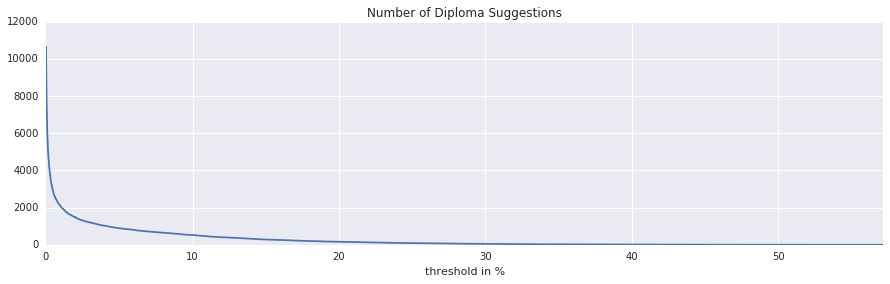

In [20]:
num_suggestions_by_thresholds = (
    # Use % instead of ratio
    (diploma_frequency.frequency * 100).
    # Sort values with more frequent first.
    sort_values(ascending=False).
    # Make a DataFrame.
    reset_index().
    # Add a column with the index which is now the number of the row,
    # or the number of rows that have a larger value.
    reset_index().
    # Keep only one value per threshold.
    groupby('frequency').index.max())
ax = num_suggestions_by_thresholds.plot(figsize=(15,4), title="Number of Diploma Suggestions")
_ = ax.set_xlabel('threshold in %')

Let's also measure the number of job groups that would get at least one recommendation (in the sample) depending on the threshold.

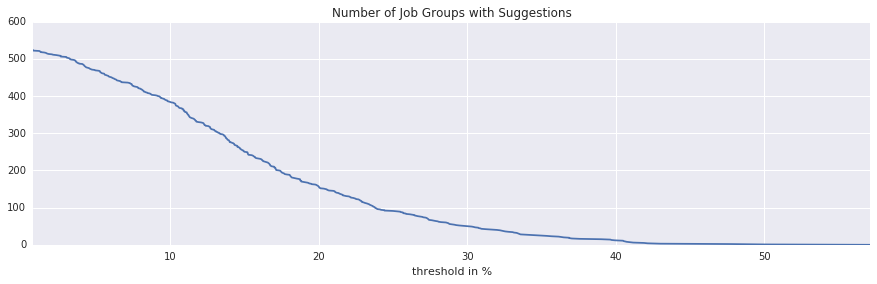

In [21]:
num_suggestions_by_job_group = (
    # Use % instead of ratio
    (diploma_frequency.frequency * 100).
    # Make a DataFrame.
    reset_index().
    # Keep only the best suggestion per job group.
    groupby('rome_profession_card_code', sort=False).frequency.max().
    # Sort values with more frequent first.
    sort_values(ascending=False).reset_index(drop=True).
    # Add a column with the index which is now the number of the row,
    # or the number of rows that have a larger value.
    reset_index().
    # Keep only one value per threshold.
    groupby('frequency').index.max()
)
#num_suggestions_by_job_group
ax = num_suggestions_by_job_group.plot(figsize=(15,4), title="Number of Job Groups with Suggestions")
_ = ax.set_xlabel('threshold in %')

If we want to have at least one recommendation (in the 10% sample) for most jobs we recommend to setting up a threshold to 5%. Let's take a look at the ones that are not vague recommendations:

In [22]:
suggestions = diploma_frequency[diploma_frequency.frequency >= 0.05].reset_index()
suggestions[suggestions.diploma.str.contains(' en ')].head(5)

,rome_profession_card_code,diploma,frequency,required_frequency
544,J1201,Bac+5 et plus ou équivalent en Médecine,0.064516,0.064516
570,J1407,"Bac+3, Bac+4 ou équivalent en Orthoptie",0.060606,0.060606
574,J1409,Bac+5 et plus ou équivalent en Podologie pédic...,0.090909,0.090909
586,J1503,"Bac+3, Bac+4 ou équivalent en Infirmier anesth...",0.061728,0.061728
629,K1402,Bac+5 et plus ou équivalent en Santé secteur s...,0.055556,0.055556


`J1201` job group "Biologie Médicale", so it's seems logical to suggest a high diploma in medecine.

Let's check how many diploma suggestions we're going to show per job group with the chosen threshold:

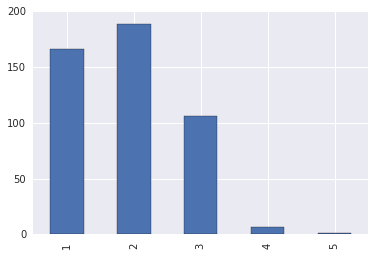

In [23]:
_ = suggestions.groupby('rome_profession_card_code').diploma.count().value_counts().sort_index().plot('bar')

In most cases we'll show 1 to 3 diplomas suggestions for a given job, in rare case we might show up to 4 or 5.

## Driving Licence Recommendation

Let's now take a look to driving licence fields. Let's use the same trick than for diplomas and check the fields named `driving` and ending by `_1`

In [24]:
driving_1_columns = [c for c in postings.columns if c.startswith('driving_') and c.endswith('_1')]
postings[driving_1_columns].dropna().head(10)

,driving_lic_code_1,driving_lic_name_1,driving_lic_req_code_1,driving_lic_req_name_1
5,B,B - Véhicule léger,S,Souhaité
11,B,B - Véhicule léger,E,Exigé
15,B,B - Véhicule léger,S,Souhaité
21,B,B - Véhicule léger,E,Exigé
22,B,B - Véhicule léger,E,Exigé
29,B,B - Véhicule léger,E,Exigé
36,EB,EB - Véhicule léger + remorque,E,Exigé
38,B,B - Véhicule léger,E,Exigé
40,B,B - Véhicule léger,E,Exigé
41,B,B - Véhicule léger,E,Exigé


Let's check how frequently these fields are populated:

In [25]:
postings[driving_1_columns + [c.replace('_1', '_2') for c in driving_1_columns]].count().to_frame() * 100 / len(postings)

,0
driving_lic_code_1,16.606120
driving_lic_name_1,16.606029
driving_lic_req_code_1,16.606120
driving_lic_req_name_1,16.606029
driving_lic_code_2,0.528707
driving_lic_name_2,16.606029
driving_lic_req_code_2,0.528707
driving_lic_req_name_2,0.528707


The first one is populated in 16.6% of job offers, and the second one is populated in 0.5%. However there's something fishy with the `driving_lic_name_2`, let's check it out:

In [26]:
len(postings[postings.driving_lic_name_1 == postings.driving_lic_name_2]) / postings.driving_lic_name_1.count()

1.0

Bummer, the `driving_lic_name_2` is a perfect duplicate of `driving_lic_name_1`. We should just ignore it. Let's make sure the code do not have the same issue:

In [27]:
len(postings[postings.driving_lic_code_1 == postings.driving_lic_code_2]) / postings.driving_lic_name_1.count()

5.4405780070074645e-06

Phew, there might be one or two cases, but it's not an issue like for the name. Let's try to recreate the name of the second field from the first one, first let's see if we can get a mapping from code to name.

In [28]:
driving_lic_mapping = postings.groupby(['driving_lic_code_1', 'driving_lic_name_1']).driving_lic_code_1.count().to_frame().reset_index(1)
driving_lic_name = driving_lic_mapping.driving_lic_name_1
driving_lic_mapping

,driving_lic_name_1,driving_lic_code_1
driving_lic_code_1,,
1,Aucun permis,6
A,A - Moto,508
A1,A1 - Motocyclette <= 125 cm3,27
A2,A2 - Moto <= 600 cm3,3
AM,AM - Cyclomoteur <= 50 cm3,82
B,B - Véhicule léger,170017
B1,B1 - Quadricycle,24
B79,B mention 79.06 (= EB),30
B96,"B mention 96 - VL + remorque (PTAC < 4,25 T)",44


There's a unique name for each code, and they clearly correspond nicely. Let's now make sure that the second list of codes are part of this:

In [29]:
driving_lic_code_2 = postings.driving_lic_code_2.dropna()
driving_lic_code_2[~driving_lic_code_2.isin(driving_lic_name.index)]

113411     00
501592    D1E
Name: driving_lic_code_2, dtype: object

Only two exceptions, we're just going to copy over the code as a name in those cases. Let's fix the `driving_lic_name_2` field now:

In [30]:
postings.loc[postings.driving_lic_name_2.notnull(), 'driving_lic_name_2'] = postings.driving_lic_code_2
postings.loc[postings.driving_lic_name_2.notnull(), 'driving_lic_name_2'] = postings.driving_lic_code_2.map(driving_lic_name)

Now that we've cleaned up the data, let's group data for 1 and 2 and drop the prefix.

In [31]:
driving_1 = postings[driving_1_columns].dropna().rename(columns=lambda name: name[:-2])
driving_2 = postings[[name + '_2' for name in driving_1.columns]].dropna().rename(columns=lambda name: name[:-2])
driving = pd.concat([driving_1, driving_2], ignore_index=True).rename(columns=lambda name: name[len('driving_lic_'):])

Let's check the existing values for `req_code` and `req_name`:

In [32]:
driving.groupby(['req_code', 'req_name']).req_code.count().to_frame()

,,req_code
req_code,req_name,
E,Exigé,144052
S,Souhaité,45602


Plain and simple, we can rely on the `req_code` field to be equivalent to the `req_name` and have exatly two values `E` (required) and `S` (suggested).

Let's see, per licence type, what is the ratio required vs suggested:

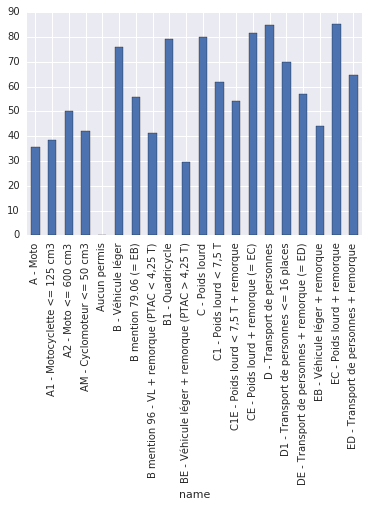

In [33]:
_ = driving.groupby('name').apply(lambda df: len(df[df.req_code == 'E']) * 100 / len(df)).plot('bar')

### Driving Licence Coverage

As we did for diplomas let's check the threshold that would make sense to recommend a licence.

In [34]:
driving_frequency = postings.groupby('rome_profession_card_code').apply(
    lambda job_offers: job_offers_lib.double_property_frequency(job_offers, column='driving_lic_name', req_column='driving_lic_req_code'))
driving_frequency.head(10)

frequency  \
rome_profession_card_code driving_lic_name                                            
A1101                     B - Véhicule léger                               0.273659   
                          C - Poids lourd                                  0.051262   
                          EC - Poids lourd + remorque                      0.033123   
                          EB - Véhicule léger + remorque                   0.010252   
                          CE - Poids lourd + remorque (= EC)               0.003155   
                          B mention 96 - VL + remorque (PTAC < 4,25 T)     0.000789   
                          BE - Véhicule léger + remorque (PTAC > 4,25 T)   0.000789   
A1201                     B - Véhicule léger                               0.338462   
                          EB - Véhicule léger + remorque                   0.069822   
                          C - Poids lourd                                  0.005917   

                                                                          required_frequency  
rome_profession_card_code driving_lic_name                                                    
A1101                     B - Véhicule léger                                        0.242902  
                          C - Poids lourd                                           0.035489  
                          EC - Poids lourd + remorque                               0.026814  
                          EB - Véhicule léger + remorque                            0.006309  
                          CE - Poids lourd + remorque (= EC)                        0.001577  
                          B mention 96 - VL + remorque (PTAC < 4,25 T)              0.000789  
                          BE - Véhicule léger + remorque (PTAC > 4,25 T)            0.000789  
A1201                     B - Véhicule léger                                        0.272189  
                          EB - Véhicule léger + remorque                            0.008284  
                          C - Poids lourd                                           0.001183

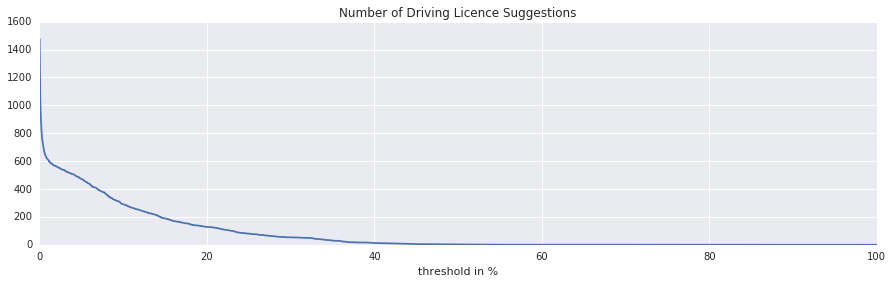

In [35]:
num_suggestions_by_thresholds = (
    # Use % instead of ratio
    (driving_frequency.frequency * 100).
    # Sort values with more frequent first.
    sort_values(ascending=False).
    # Make a DataFrame.
    reset_index().
    # Add a column with the index which is now the number of the row,
    # or the number of rows that have a larger value.
    reset_index().
    # Keep only one value per threshold.
    groupby('frequency').index.max())
ax = num_suggestions_by_thresholds.plot(figsize=(15,4), title="Number of Driving Licence Suggestions")
_ = ax.set_xlabel('threshold in %')

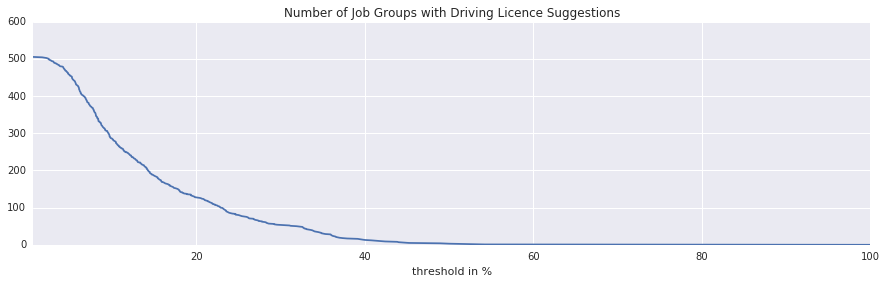

In [36]:
num_suggestions_by_job_group = (
    # Use % instead of ratio
    (driving_frequency.frequency * 100).
    # Make a DataFrame.
    reset_index().
    # Keep only the best suggestion per job group.
    groupby('rome_profession_card_code', sort=False).frequency.max().
    # Sort values with more frequent first.
    sort_values(ascending=False).reset_index(drop=True).
    # Add a column with the index which is now the number of the row,
    # or the number of rows that have a larger value.
    reset_index().
    # Keep only one value per threshold.
    groupby('frequency').index.max()
)
ax = num_suggestions_by_job_group.plot(figsize=(15,4), title="Number of Job Groups with Driving Licence Suggestions")
_ = ax.set_xlabel('threshold in %')

A threshold of 5% looks good, but let's check the distribution, first per job group:

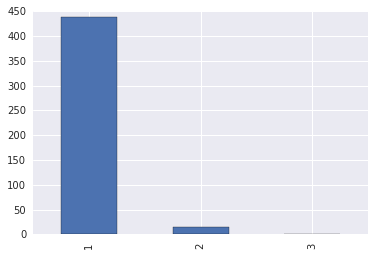

In [37]:
suggestions = driving_frequency[driving_frequency.frequency >= 0.05].reset_index()
_ = suggestions.groupby('rome_profession_card_code').driving_lic_name.count().value_counts().sort_index().plot('bar')

Now per type of licence recommended:

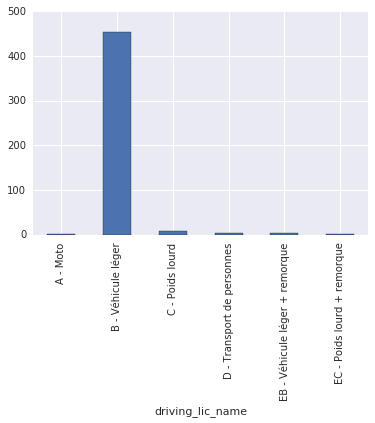

In [38]:
_ = suggestions.groupby('driving_lic_name').rome_profession_card_code.count().plot('bar')

As expected the standard driving licence is the one that's mostly recommended (and that for more than 450 job groups out of 530), but other might be recommended as well. Just as a safety, let's see for which job group would we recommend something else than the standard driving licence:

In [39]:
suggestions[~suggestions.driving_lic_name.str.startswith('B - ')].head(10)

,rome_profession_card_code,driving_lic_name,frequency,required_frequency
1,A1101,C - Poids lourd,0.051262,0.035489
3,A1201,EB - Véhicule léger + remorque,0.069822,0.008284
27,A1502,EB - Véhicule léger + remorque,0.050000,0.000000
118,F1105,EB - Véhicule léger + remorque,0.077922,0.034632
129,F1401,EB - Véhicule léger + remorque,0.057554,0.043165
264,I1202,C - Poids lourd,0.121842,0.084695
288,I1607,A - Moto,0.080876,0.062342
339,K1705,C - Poids lourd,0.054264,0.015504
360,K2301,C - Poids lourd,0.108491,0.083333
432,N1102,C - Poids lourd,0.097372,0.077280


The first one `A1502` is `Podologie animale`, where we're suggesting to be able to drive a car with a trailer or even a truck: that can make sense if you need to transport some animals.

Overall the data about driving licence is pretty clean (apart from the driving licence name that is a duplicate), we should be able to make good recommendations out of it using the fields `driving_lic_code_*` and using a 5% threshold to suggest it for a job group. To display nice names we can use the `driving_lic_name_1` and to reconstruct the name from the `driving_lic_code_2` we can use this dict:

In [40]:
driving_lic_name.to_dict()

{'1': 'Aucun permis',
 'A': 'A - Moto',
 'A1': 'A1 - Motocyclette <= 125 cm3',
 'A2': 'A2 - Moto <= 600 cm3',
 'AM': 'AM - Cyclomoteur <= 50 cm3',
 'B': 'B - Véhicule léger',
 'B1': 'B1 - Quadricycle',
 'B79': 'B mention 79.06 (= EB)',
 'B96': 'B mention 96 - VL + remorque (PTAC < 4,25 T)',
 'BE': 'BE - Véhicule léger + remorque (PTAC > 4,25 T)',
 'C': 'C - Poids lourd',
 'C1': 'C1 - Poids lourd < 7,5 T',
 'C1E': 'C1E - Poids lourd < 7,5 T + remorque',
 'CE': 'CE - Poids lourd + remorque (= EC)',
 'D': 'D - Transport de personnes',
 'D1': 'D1 - Transport de personnes <= 16 places',
 'DE': 'DE - Transport de personnes + remorque (= ED)',
 'EB': 'EB - Véhicule léger + remorque',
 'EC': 'EC - Poids lourd + remorque',
 'ED': 'ED - Transport de personnes + remorque'}

## Desktop Tools Recommendations

Now let's check out the desktop tools fields.

In [41]:
desktop_1_columns = [c for c in postings.columns if c.startswith('desktop_') and c.endswith('_1')]
postings[desktop_1_columns].dropna().head(10)

,desktop_tools_code_1,desktop_tools_name_1,desktop_tools_lev_code_1,desktop_tools_lev_name_1
26,TA,Tableur,2,Utilisation normale
52,TA,Tableur,1,Utilisation experte
54,TA,Tableur,2,Utilisation normale
68,TT,Traitement de texte,1,Utilisation experte
79,TA,Tableur,1,Utilisation experte
126,TA,Tableur,1,Utilisation experte
145,TT,Traitement de texte,1,Utilisation experte
162,TT,Traitement de texte,2,Utilisation normale
164,TA,Tableur,2,Utilisation normale
166,TA,Tableur,2,Utilisation normale


Let's check how frequent these fields are:

In [42]:
postings[[c for c in postings.columns if c.startswith('desktop')]].count().to_frame() * 100 / len(postings)

,0
desktop_tools_code_1,7.405242
desktop_tools_name_1,7.405152
desktop_tools_lev_code_1,76.304218
desktop_tools_lev_name_1,0.981072
desktop_tools_code_2,6.320002
desktop_tools_name_2,6.320002
desktop_tools_lev_code_2,76.304308
desktop_tools_lev_name_2,0.850702


So the deskop tools are recommended in 7% of job offers, and in 6% of them there's a second one. However the level code seems to be present more often than the tools themselves so further on we'll filter on rows having `desktop_tools_code_*` set

Let's also check whether tools 1 and tools 2 happen to be the same:

In [43]:
len(postings[postings.desktop_tools_code_1 == postings.desktop_tools_code_2])

0

In [44]:
len(postings[postings.desktop_tools_code_2.notnull() & postings.desktop_tools_code_1.isnull()])

0

Cool there are always different, and we only have tools 2 when we also have tools 1. Let's group data for 1 and 2 and drop the prefix.

In [45]:
desktop_1 = postings[desktop_1_columns].dropna(subset=['desktop_tools_code_1']).rename(columns=lambda name: name[:-2])
desktop_2 = postings[[name + '_2' for name in desktop_1.columns]].dropna(subset=['desktop_tools_code_2']).rename(columns=lambda name: name[:-2])
desktop = pd.concat([desktop_1, desktop_2], ignore_index=True).rename(columns=lambda name: name[len('desktop_tools_'):])

Now let's check the existing values for code and name:

In [46]:
desktop.groupby(['code', 'name']).lev_code.count().to_frame()

,,lev_code
code,name,
0,Autre,1
B,B - Véhicule léger,1
BREST,01,1
TA,Tableur,73589
TT,Traitement de texte,78249


So there is some little noise, but very clear values `TA` and `TT`. From now on we're going to filter on those.

Let's check the different levels:

In [47]:
desktop[desktop.code.str.startswith('T')].groupby(['lev_code', 'lev_name']).code.count().to_frame()

,,code
lev_code,lev_name,
1,Utilisation experte,4104
2,Utilisation normale,14900
3,Notions,1002
1,Utilisation experte,65
2,Utilisation normale,194
3,Notions,7


The duplicate rows are due to a column type mismatch between the field 1 and field 2 (because some rows have a value that is not an integer, the CSV parser was able to convert one of the field to integer, but not the other one). However for the rows that concern us, the picture is pretty clear: three different levels of expertise, 1 being the top one, and 3 being the lowest.

### Desktop Tool Coverage

As we did for other fields let's check the threshold that would make sense to recommend a desktop tool.

In [48]:
desktop_frequency = postings.groupby('rome_profession_card_code').apply(
    lambda job_offers: job_offers_lib.double_property_frequency(job_offers, column='desktop_tools_name', req_column='desktop_tools_name'))
desktop_frequency = desktop_frequency[desktop_frequency.index.get_level_values('desktop_tools_name').str.startswith('T')]
desktop_frequency.head(10)

frequency  required_frequency
rome_profession_card_code desktop_tools_name                                
A1101                     Tableur               0.003943                 0.0
                          Traitement de texte   0.002366                 0.0
A1201                     Tableur               0.002367                 0.0
                          Traitement de texte   0.002367                 0.0
A1202                     Traitement de texte   0.002959                 0.0
                          Tableur               0.001479                 0.0
A1203                     Traitement de texte   0.014436                 0.0
                          Tableur               0.004846                 0.0
A1204                     Traitement de texte   0.184615                 0.0
                          Tableur               0.169231                 0.0

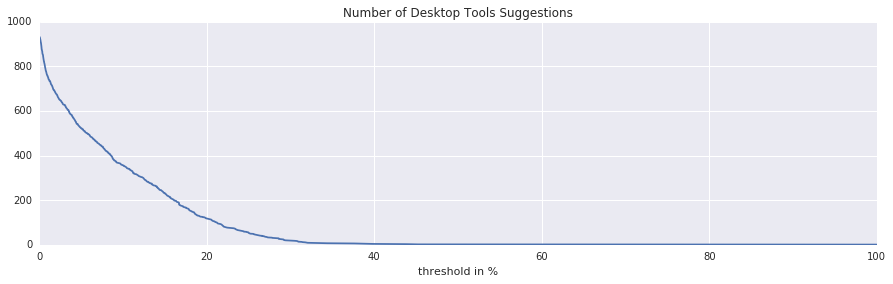

In [49]:
num_suggestions_by_thresholds = (
    # Use % instead of ratio
    (desktop_frequency.frequency * 100).
    # Sort values with more frequent first.
    sort_values(ascending=False).
    # Make a DataFrame.
    reset_index().
    # Add a column with the index which is now the number of the row,
    # or the number of rows that have a larger value.
    reset_index().
    # Keep only one value per threshold.
    groupby('frequency').index.max())
ax = num_suggestions_by_thresholds.plot(figsize=(15,4), title="Number of Desktop Tools Suggestions")
_ = ax.set_xlabel('threshold in %')

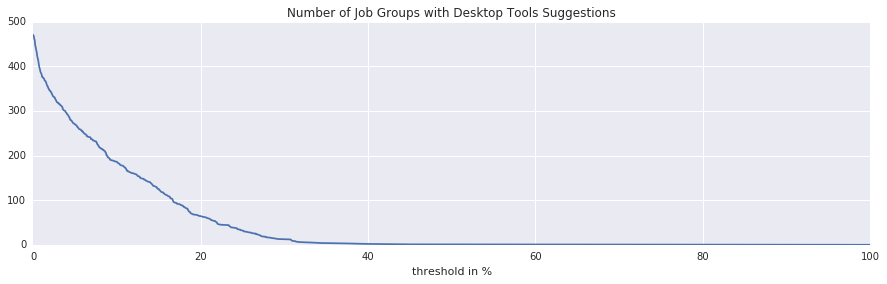

In [50]:
num_suggestions_by_job_group = (
    # Use % instead of ratio
    (desktop_frequency.frequency * 100).
    # Make a DataFrame.
    reset_index().
    # Keep only the best suggestion per job group.
    groupby('rome_profession_card_code', sort=False).frequency.max().
    # Sort values with more frequent first.
    sort_values(ascending=False).reset_index(drop=True).
    # Add a column with the index which is now the number of the row,
    # or the number of rows that have a larger value.
    reset_index().
    # Keep only one value per threshold.
    groupby('frequency').index.max()
)
ax = num_suggestions_by_job_group.plot(figsize=(15,4), title="Number of Job Groups with Desktop Tools Suggestions")
_ = ax.set_xlabel('threshold in %')

Hmm, hard to say where we should set the limit. Let's take a look at the actual job groups.

In [51]:
job_groups = cleaned_data.rome_job_groups(data_folder='../../data')
desktop_frequency_with_name = desktop_frequency.reset_index(1)
desktop_frequency_with_name['job_group_name'] = job_groups.name
desktop_frequency_with_name['frequency_percent'] = desktop_frequency_with_name.frequency * 100
desktop_frequency_with_name = desktop_frequency_with_name.sort_values('frequency', ascending=True)[
    ['job_group_name', 'frequency_percent', 'desktop_tools_name']]
desktop_frequency_with_name.head(10)

,job_group_name,frequency_percent,desktop_tools_name
rome_profession_card_code,,,
A1401,Aide agricole de production fruitière ou viticole,0.029283,Tableur
A1401,Aide agricole de production fruitière ou viticole,0.029283,Traitement de texte
F1608,Pose de revêtements rigides,0.048333,Tableur
F1608,Pose de revêtements rigides,0.048333,Traitement de texte
G1604,Fabrication de crêpes ou pizzas,0.070472,Traitement de texte
F1611,Réalisation et restauration de façades,0.072464,Traitement de texte
F1611,Réalisation et restauration de façades,0.072464,Tableur
G1605,Plonge en restauration,0.073964,Tableur
K1304,Services domestiques,0.082553,Tableur


OK, those first ones do not need office tools (cooking pizzas, washing dishes, helping out for fruits collection, etc.) Let's check those that are above 5%.

In [52]:
desktop_frequency_with_name[desktop_frequency_with_name.frequency_percent > 5].head(10)

,job_group_name,frequency_percent,desktop_tools_name
rome_profession_card_code,,,
G1802,Management du service en restauration,5.069802,Tableur
H2804,"Pilotage de centrale à béton prêt à l'emploi, ...",5.076142,Traitement de texte
D1205,Nettoyage d'articles textiles ou cuirs,5.082508,Tableur
H2204,Encadrement des industries de l'ameublement et...,5.128205,Tableur
H1204,Design industriel,5.217391,Tableur
N1103,Magasinage et préparation de commandes,5.221901,Traitement de texte
D1506,Marchandisage,5.223881,Tableur
J1306,Imagerie médicale,5.228758,Tableur
J1506,Soins infirmiers généralistes,5.253961,Traitement de texte


If I (Pascal) would classify manually I would indeed suggest the recommended tool once every two lines but only weakly. As we don't mind giving the suggestions a bit too frequently we're going to go with a threshold of 5%.

Overall this dataset contains useful data for desktop office tools expertise, the fields `desktop_tools_name_*` can be used if they start with a `T` and we can recommend it for a job group as soon as there is more than 5% of job offers that requires it for this job group. The level of expertise in the `desktop_tools_lev_code_*` fields (1 - expert, 2 - normal use, 3 - vague idea) can be used as well.

## Data availability per job

,Postings per job group (top 15)
Personnel de cuisine,36134
Nettoyage de locaux,30030
Assistance auprès d'enfants,28578
Services domestiques,27861
Service en restauration,27391
Comptabilité,21331
Assistanat commercial,18766
Assistance auprès d'adultes,17834
Relation commerciale auprès de particuliers,17725
Enseignement général du second degré,17693


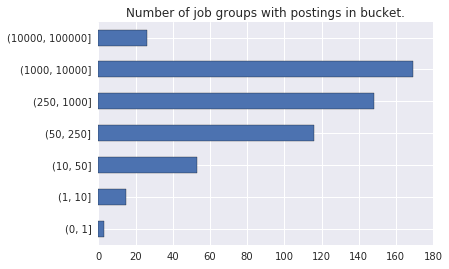

In [53]:
rome_counts = postings.rome_profession_card_name.value_counts()
bins = [0, 1, 10, 50, 250, 1000, 10000, 100000]
binned = pd.cut(rome_counts, bins)
ax = binned.value_counts().sort_index().plot(kind='barh')
ax.set_title('Number of job groups with postings in bucket.')
rome_counts.head(20).to_frame(name='Postings per job group (top 15)')

## Are skills listed for most of the offers?

In [54]:
postings.rome_list_skill_code.notnull().sum() / len(postings)

0.15471007389431821

That's only very little. But let's check, if they list the skills, how extensive is this list?

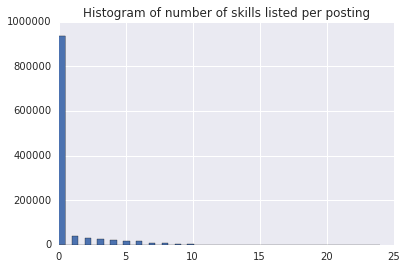

In [55]:
skill_count = postings.rome_list_skill_code.fillna('').str.split('|').map(len) - 1
ax = skill_count.hist(bins=50)
_ = ax.set_title('Histogram of number of skills listed per posting')

That does not seem very useful. :-(

## Single job group analysis

Let's pick one for which we have enough information, but not the most common one.

==> M1601: Accueil et renseignements  

In [56]:
rome_id = 'M1601'
single_rome = postings[postings.rome_profession_card_code == rome_id].copy()

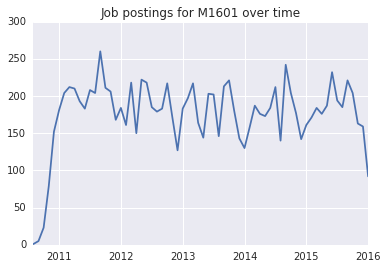

In [57]:
single_rome_ts = single_rome.set_index(pd.DatetimeIndex(single_rome.creation_date))
ax = single_rome_ts.resample('M').id_offre.count().plot(kind='line')
_ = ax.set_title('Job postings for %s over time' % rome_id)

There seems to be a lower number of job posts towards the end of the year.

## Relationship between minimum salary and number of postings

99.94% of values in range


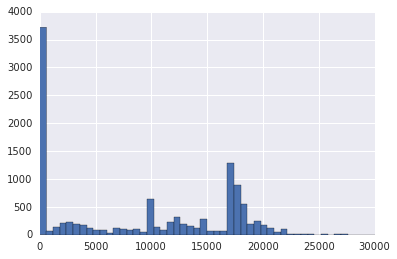

In [58]:
salary = single_rome.annual_minimum_salary.astype(float)
_ = plot_helpers.hist_in_range(salary, max_value=30000)

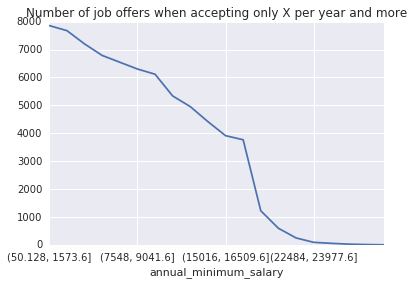

In [59]:
N_BUCKETS = 20
MAX_SALARY = 30000

single_rome['annual_minimum_salary'] = single_rome.annual_minimum_salary.astype(float)
valid_salary_mask = (single_rome.annual_minimum_salary > 0) & (single_rome.annual_minimum_salary < MAX_SALARY)
valid_salary = single_rome[valid_salary_mask]
buckets = pd.cut(valid_salary.annual_minimum_salary, N_BUCKETS)
per_bucket = valid_salary.groupby(buckets).id_offre.count().to_frame()
per_bucket['bucket_sum'] = per_bucket.sort_index(ascending=False).cumsum()
ax = per_bucket.bucket_sum.plot(kind='line')
_ = ax.set_title('Number of job offers when accepting only X per year and more')

## Conclusion

This seems to be a very rich and relatively good quality dataset. Seems like we can use it for suggestions like 'If you lower your requested yearly salary by 500 euro, you will have 15% more job posts available.

To use the diploma required or suggested for each job or job group, we recommend using the name of the type of the diploma combined with the domain if it has any, and we should recommend a diploma for a job group if it's recommended for more than 5% of the offers of a job group.